In [11]:
# Adding the neccecary imports to our code
import numpy as np
import matplotlib.pyplot as plt
import pydot # conda install pydot
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.collections as collections
from data_structures import Edge,Vertex,Graph,create_custom_graph,Forced_vertex

In [12]:
#type of data:
url_Les_Miserables_network  = '../data/LesMiserables.dot'
url_Rome_graph  = '../data/rome.dot'
url_Jazz_Network  = '../data/JazzNetwork.dot'
url_Small_Directed_Network  = '../data/noname.dot'
url_Pro_League_Network  = '../data/LeagueNetwork.dot'
url_Argumentation_network  = '../data/devonshiredebate_withclusters.dot'
url_Argumentation_network_for_part_five = '../data/devonshiredebate_withonlytwoclusters.dot'
url_Political_blogosphere_network  = '../data/polblogs.dot'


## Functions from part 3

In [13]:
def initialize_Forced_vertices(graph):
    vertices = {v.id: Forced_vertex(v.id) for v in graph.vertices}

    return vertices
def update_positions(vertices, dt=0.1, damping=0.99):
    max_movement = 0.0
    for vertex in vertices.values():
        movement = np.linalg.norm(vertex.force * dt)
        vertex.position += vertex.force * dt
        vertex.force *= damping
        max_movement = max(max_movement, movement)
    return max_movement
def compute_forces(vertices, edge,edge_set, Cspring=2.0, Crep=1.0, l=1.0):
    for vertex in vertices.values():
        vertex.force.fill(0)

    for vertex_source in vertices.values():
        for vertex_target in vertices.values():
            if vertex_source.id != vertex_target.id:
                if not is_edge_between_vertices(vertex_source.id, vertex_target.id, edge_set): # Calculate repulsive forces between all nodes
                    direction = vertex_target.position - vertex_source.position
                    distance = np.linalg.norm(direction)
                    if distance > 0:
                        unit_vector = direction / distance
                        force = (Crep / distance ** 2) * unit_vector
                        vertex_target.force += force
                else: # Calculate atractive forces between all nodes
                    direction = vertex_source.position - vertex_target.position
                    distance = np.linalg.norm(direction)
                    if distance > 0:
                        unit_vector = direction / distance
                        force = Cspring * np.log10(distance / l) * unit_vector
                        vertex_target.force += force
def is_edge_between_vertices(source_id, target_id, edge_set):
    return (source_id, target_id) in edge_set or (target_id, source_id) in edge_set

In [14]:
def separate_subgraphs(graph):
    subgraph_edges = {}
    subgraph_vertices = []
    inter_subgraph_edges = {}

    # Iterate through each cluster in the graph
    for i, subgraph in enumerate(graph.get_subgraphs()):
        subgraph_vertices.append(subgraph.get_node_list())
        subgraph_edges[i] = []

    # Initialize inter-cluster edges for each pair of clusters
    for i in range(len(subgraph_vertices)):
        for j in range(i + 1, len(subgraph_vertices)):
            inter_subgraph_edges[(i, j)] = []

    # Collect edges connecting vertices from different clusters
    for edge in graph.get_edge_list():
        source_vertex = edge.get_source()
        target_vertex = edge.get_destination()
        source_subgraph = None
        target_subgraph = None

        # Find which cluster each node belongs to
        for i, vertices in enumerate(subgraph_vertices):
             for vertex in vertices:
                if vertex.get_name() == source_vertex:
                    source_subgraph = i
                if vertex.get_name() == target_vertex:
                    target_subgraph = i

        # If the edge connects vertices from different clusters, add it to the inter-cluster edges
        if source_subgraph is not None and target_subgraph is not None:
            if source_subgraph != target_subgraph:
                inter_subgraph_edges[(min(source_subgraph, target_subgraph), max(source_subgraph, target_subgraph))].append(edge)
            else:
                subgraph_edges[source_subgraph].append(edge)

    return subgraph_vertices, subgraph_edges, inter_subgraph_edges


In [15]:
def create_forced_subgraphs(ax,ax2,graph,boundry_box,num_iterations=1000,Cspring = 2.0, Crep=1.0, l=1.0,e=0.05,learning_rate=0.1,title = ""):

    min_x, min_y = bounding_box['min_x'], bounding_box['min_y']
    width, height = bounding_box['width'], bounding_box['height']
    vertices = initialize_Forced_vertices(graph)
    for vertex in vertices.items():
        vertex[1].position = np.array([np.random.uniform(min_x,min_x + width), np.random.uniform(min_y,min_y+height)])  # Random initial position
    edges = graph.edges
    edge_set = {(edge.start.id, edge.end.id) for edge in edges}
    k = 0
    max_movement = 1
    while k < num_iterations and max_movement > e:
        compute_forces(vertices, edges,edge_set)
        max_movement = update_positions(vertices,learning_rate)
        k += 1
        if max_movement <= e:
            print(k)
    visualize_layout_subplots(ax,vertices, edges,boundry_box,title)
    visualize_layout_subplots(ax2,vertices, edges,boundry_box,title)
    return vertices

In [16]:
def visualize_layout_subplots(ax,vertices, edges,box,title):
    min_x, min_y = box['min_x'], box['min_y']
    width, height = box['width'], box['height']
    for vertex in vertices.values():
        x = vertex.position[0]
        y = vertex.position[1]
        if x < min_x:
            x = min_x + 2
        elif x > min_x + width:
            x = min_x + width - 2
        if y < min_y:
            y = min_y + 2
        elif y > min_y + height:
            y = min_y + height - 2
        vertex.position = (x,y)
    norms = [np.linalg.norm(vertex.force) for vertex in vertices.values()]
    norm = Normalize(vmin=min(norms), vmax=max(norms))

    color = np.random.rand(3,)
    rect = plt.Rectangle((min_x, min_y), width, height, linewidth=1, edgecolor='none', facecolor=color,alpha=0.25)
    ax.add_patch(rect)
    for edge in edges:
        source_pos = vertices[edge.start.id].position
        target_pos = vertices[edge.end.id].position
        ax.plot([source_pos[0], target_pos[0]], [source_pos[1], target_pos[1]], 'k-', linewidth=0.2)
    for vertex in vertices.values():
        color_rgba = plt.cm.YlOrRd(norm(np.linalg.norm(vertex.force)))
        color_hex = mcolors.rgb2hex(color_rgba[:3])
        ax.plot(vertex.position[0],vertex.position[1], 'o', color=color_hex)
        ax.text(vertex.position[0], vertex.position[1], str(vertex.id), fontsize=8, ha='center', va='bottom', color="green")
        ax.set_title(title, fontsize=30)

In [17]:
def create_custom_graph_from_subgraph(vertices,edges): # O(V) + O(E) + O(V) + O(E) = O(2V + 2E) = O(V + E)
    # Parsing the vertices and edges from the generated graph into lists
    vertices = [n.get_name() for n in vertices] # O(V)
    edges = [(edge.get_source(),edge.get_destination(),edge.get_weight()) for edge in edges] # O(E)
    graph = Graph()
    for vertex in vertices: # O(V)
        vertex = Vertex(vertex, 0, 0)  # Initialize the vertex with ID and default coordinates
        graph.add_vertex(vertex)
    for edge in edges: # O(E)
        source_vertex = graph.get_vertex(edge[0])
        neighbor_vertex = graph.get_vertex(edge[1])
        if source_vertex is None:
            source_vertex = Vertex(edge[0], 0, 0)
        if neighbor_vertex is None:
            neighbor_vertex = Vertex(edge[1], 0, 0)
        source_vertex.add_neighbor(neighbor_vertex)
        graph.add_edge(Edge(source_vertex, neighbor_vertex))
    return graph

In [146]:
def subdivide_edge(edges, num_points):
    segment_vecs = edges[:, 1:] - edges[:, :-1]
    segment_lens = np.linalg.norm(segment_vecs, axis=-1)
    cum_segment_lens = np.cumsum(segment_lens, axis=1)
    cum_segment_lens = np.hstack(
        [np.zeros((cum_segment_lens.shape[0], 1)), cum_segment_lens]
    )

    total_lens = cum_segment_lens[:, -1]
    t = np.linspace(0, 1, num=num_points, endpoint=True)
    desired_lens = t * total_lens[:, None]
    # Which segment should the new point be interpolated on
    i = np.argmax(desired_lens[:, None] < cum_segment_lens[..., None], axis=1)
    # At what percentage of the segment does this new point actually appear
    pct = (desired_lens - np.take_along_axis(cum_segment_lens, i - 1, axis=-1)) / (
        np.take_along_axis(segment_lens, i - 1, axis=-1) + 1e-8
    )

    row_indices = np.arange(edges.shape[0])[:, None]
    new_points = (
        (1 - pct[..., None]) * edges[row_indices, i - 1]
        + pct[..., None] * edges[row_indices, i]
    )

    return new_points


def compute_edge_compatibility(edges):

    vec = edges[:, -1] - edges[:, 0]
    vec_norm = np.linalg.norm(vec, axis=1, keepdims=True)
    epsilon = 1e-8

    # Angle compatibility
    cos_theta = np.einsum('ik,jk->ij', vec, vec) / (vec_norm @ vec_norm.T + epsilon)
    compat_angle = np.abs(cos_theta)

    # Length compatibility
    l_avg = (vec_norm + vec_norm.T) / 2
    min_norm = np.minimum(vec_norm, vec_norm.T)
    max_norm = np.maximum(vec_norm, vec_norm.T)
    compat_length = 2 / (l_avg / (min_norm + epsilon) + max_norm / (l_avg + epsilon) + epsilon)

    # Distance compatibility
    midpoint = (edges[:, 0] + edges[:, -1]) / 2
    midpoint_dist = np.linalg.norm(midpoint[None, :] - midpoint[:, None], axis=-1)
    compat_dist = l_avg / (l_avg + midpoint_dist + epsilon)

    # Calculate projection vector
    projection_vector = edges[None, ...] - edges[:, None, None, 0]
    
    transformation = np.sum(projection_vector * vec[:, None, None, :], axis=-1) / (np.sum(vec**2, axis=-1)[:, None, None] + epsilon)
    I = edges[:, None, 0, None] + transformation[..., None] * vec[:, None, None, :]

    # Calculate midpoints and distances
    Im = (I[..., 0, :] + I[..., 1, :]) / 2
    midpoint = (edges[:, 0] + edges[:, -1]) / 2
    denom = np.sqrt(np.sum((I[..., 0, :] - I[..., 1, :]) ** 2, axis=-1))
    num = 2 * np.linalg.norm(midpoint[:, None, ...] - Im, axis=-1)

    # Compute visibility compatibility
    compat_visibility = np.maximum(0, 1 - num / (denom + epsilon))
    compat_visibility = np.minimum(compat_visibility, compat_visibility.T)

    # Combine compatibility scores
    return compat_angle * compat_length * compat_dist * compat_visibility

def compute_forces_new(edges, e_compat, kp, electro_factor=0.275):
    # Left-mid spring direction
    v_spring_l = edges[:, :-1] - edges[:, 1:]
    v_spring_l = np.concatenate(
        [np.zeros((v_spring_l.shape[0], 1, v_spring_l.shape[-1])), v_spring_l],
        axis=1,)

    # Right-mid spring direction
    v_spring_r = edges[:, 1:] - edges[:, :-1]
    v_spring_r = np.concatenate(
        [v_spring_r, np.zeros((v_spring_l.shape[0], 1, v_spring_l.shape[-1]))],
        axis=1,)

    f_spring_l = np.sum(v_spring_l ** 2, axis=-1, keepdims=True)
    f_spring_r = np.sum(v_spring_r ** 2, axis=-1, keepdims=True)

    F_spring = kp * (f_spring_l * v_spring_l + f_spring_r * v_spring_r)

    # Electrostatic force
    v_electro = edges[:, None, ...] - edges[None, ...]
    f_electro = e_compat[..., None] / (np.linalg.norm(v_electro, axis=-1) + 1e-8)

    # Reduce the influence of electrostatic force
    F_electro = np.sum(f_electro[..., None] * v_electro, axis=0) * electro_factor

    F = F_spring + F_electro
    # The first and last points are fixed
    F[:, 0, :] = F[:, -1, :] = 0

    return F
def bundling_edges(edges,K = 0.1,n_iter = 60,n_iter_reduction = 2 / 3,lr = 0.04,lr_reduction = 0.5,
                   n_cycles = 6,initial_segpoints = 1,segpoint_increase = 2,compat_threshold = 0.05):
    initial_edge_vecs = edges[:, 0] - edges[:, -1]
    initial_edge_lengths = np.linalg.norm(initial_edge_vecs, axis=-1, keepdims=True)

    # Compute edge compatibilities
    edge_compatibilities = compute_edge_compatibility(edges)
    edge_compatibilities = (edge_compatibilities > compat_threshold).astype(np.float32)

    num_segments = initial_segpoints

    for cycle in range(n_cycles):
        edges = subdivide_edge(edges, num_segments + 2)  # Add 2 for endpoints
        num_segments = int(np.ceil(num_segments * segpoint_increase))

        kp = K / (initial_edge_lengths * num_segments + 1e-8)
        kp = kp[..., None]

        for epoch in range(n_iter):
            F = compute_forces_new(edges, edge_compatibilities, kp)
            edges += F * lr
        n_iter = int(np.ceil(n_iter * n_iter_reduction))
        lr = lr * lr_reduction

    return edges

In [147]:
def compact_edges(cur_edges,subGraph1, subGraph2):
    e = []
    for edge in cur_edges:
        if edge.get_source() in subGraph1:
            start = np.array(subGraph1[edge.get_source()].position)
            end = np.array(subGraph2[edge.get_destination()].position)
        else:
            start = np.array(subGraph2[edge.get_source()].position)
            end = np.array(subGraph1[edge.get_destination()].position)
        e.append((start, end))
    return np.array(e)

103
89
190
27
87
263
147
40
4
43
136


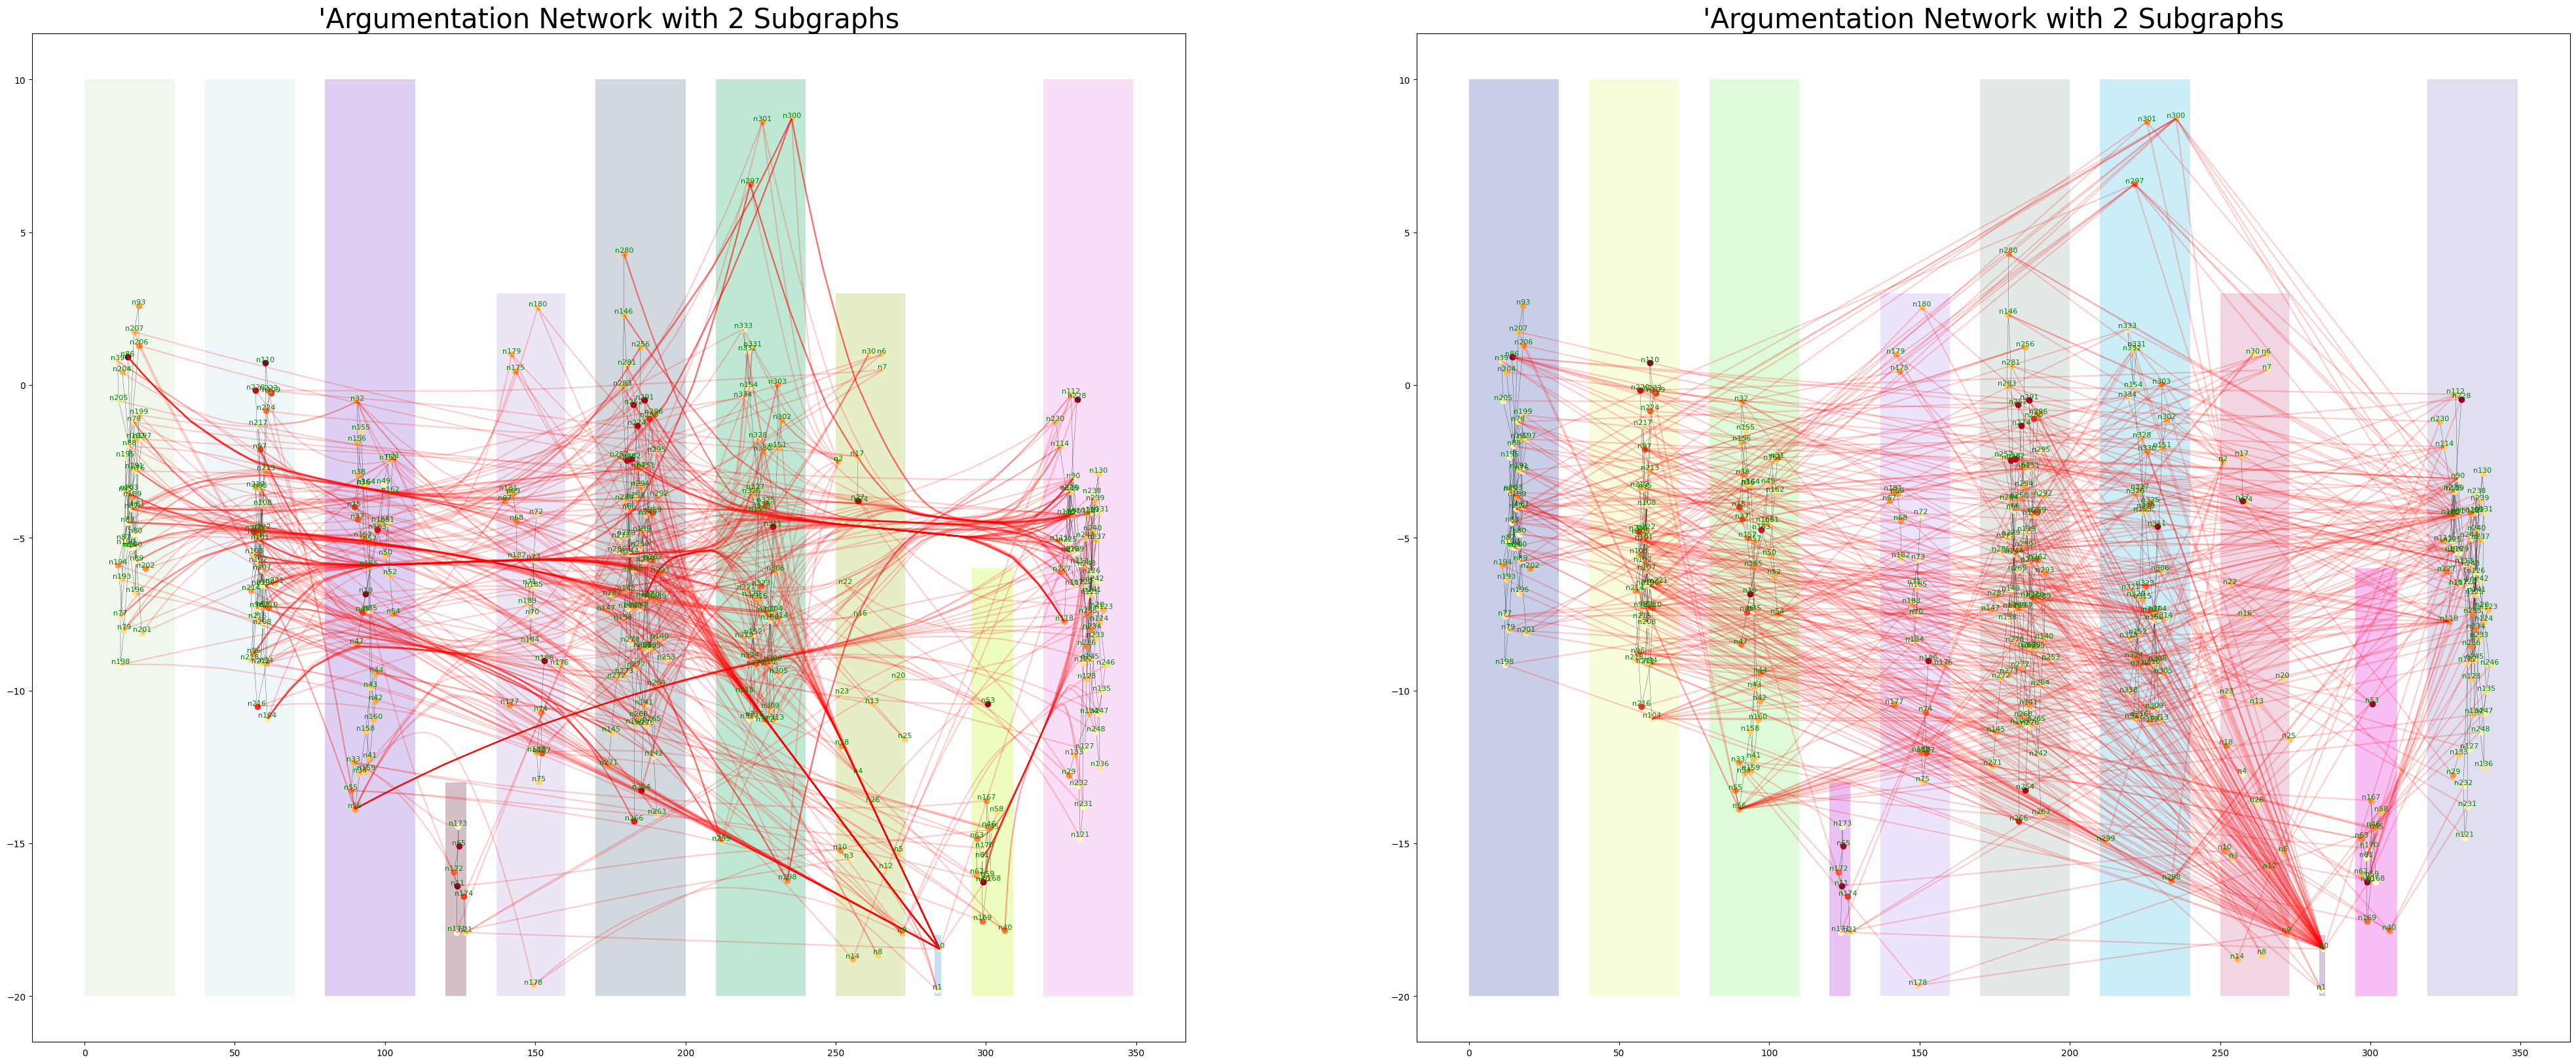

In [148]:

G=pydot.graph_from_dot_file(url_Argumentation_network)[0]
subgraph_vertices, subgraph_edges, inter_subgraph_edges = separate_subgraphs(G)
fig,axs = plt.subplots(1,2,figsize=(50,20))
threshold = 0.05
learning_rate = 0.1
current_position =(0, -20)
padding=10
graph_list = []
for i in range(len(subgraph_vertices)):
    width = height = min(len(subgraph_vertices[i]),30)
    min_x, min_y = current_position
    max_x = min_x + width
    max_y = min_y + height
    bounding_box = {
            'min_x': min_x,
            'min_y': min_y,
            'width': width,
            'height': height
        }
    graph = create_custom_graph_from_subgraph(subgraph_vertices[i],subgraph_edges[i])
    graph_list.append(create_forced_subgraphs(axs[0],axs[1], graph,bounding_box,1000,2,1,0.5,0.05,0.1,"'Argumentation Network with 2 Subgraphs"))
    current_position = (max_x + padding, min_y)
for index,cur_edges in inter_subgraph_edges.items():
    if len(cur_edges) == 0:
        continue
    subGraph1 = graph_list[index[0]]
    subGraph2 = graph_list[index[1]]
    edges = compact_edges(cur_edges,subGraph1, subGraph2)
    
    bundled_inter_cluster_edges = bundling_edges(edges)    
    start = None
    end = None
    collection = collections.LineCollection(bundled_inter_cluster_edges, color="r", alpha=0.2)
    collection2 = collections.LineCollection(edges, color="r", alpha=0.2)
    axs[0].add_collection(collection)
    axs[1].add_collection(collection2)